#LSTM NN con FASHION MNIST, versione GPU

*Long-Short Term Memory* neural network sviluppata in TensorFlow versione 1.x, su database FASHION MNIST; costruita per usufruire della GPU, ossia con CuDNN.

In questo notebook lo scopo è testare il modello con un altro database; per spiegazioni più dettagliate, guardare la versione corrispondente al modello su database MNIST.

In [0]:
%tensorflow_version 1.x

In [63]:
import tensorflow as tf
from tensorflow import keras as ks

#tf.reset_default_graph()

#RNN Cells and additional RNN operations.
#contrib è un modulo "sperimentale" in TF 1.x; aggiunto in TF 2.x
#from tensorflow.contrib import rnn
#Preferisco utilizzare keras (come built-in in TensorFlow) che le strutture in tf

print(tf.__version__)

1.15.0


In [64]:
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax

#Per interoperabilità di Python 2/3
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from numpy import array
from numpy import argmax

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix
#Per data visualization
import seaborn as sns

import time

print("Done")

Done


##Devices utilizzati

Test per vedere che device sono utilizzati.

In [65]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7348328943369321622
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 453189706546889314
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8627343067113491524
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7470045594
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2725312592095052336
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


##Altri metodi

In [66]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

print("Done")

Done


In [67]:
class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

print("Done")

Done


##Import dei dati

In [68]:
#Import del database MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#Struttura dati nel database
print("Numero elementi e dimensione immagini in train set: " + str(train_images.shape))
print("Numero elementi e dimensione immagini in test set: " + str(test_images.shape))
print("Numero elementi label in train set: " + str(len(train_labels)))
print("Numero elementi label in test set: " + str(len(test_labels)))
print("Tipo di struttura del train set: " + str(type(train_images)) + ", composto da " + str(type(train_images[0])))
print("Tipo di struttura del label set: " + str(type(train_labels)) + ", composto da " + str(type(train_labels[0])))
print("Le etichette sono interi; valore più piccolo: " + str(np.amin(train_labels)) + ", valore più grande: " + str(np.amax(train_labels)))

Numero elementi e dimensione immagini in train set: (60000, 28, 28)
Numero elementi e dimensione immagini in test set: (10000, 28, 28)
Numero elementi label in train set: 60000
Numero elementi label in test set: 10000
Tipo di struttura del train set: <class 'numpy.ndarray'>, composto da <class 'numpy.ndarray'>
Tipo di struttura del label set: <class 'numpy.ndarray'>, composto da <class 'numpy.uint8'>
Le etichette sono interi; valore più piccolo: 0, valore più grande: 9


##Costanti e parametri

In [69]:
#Costanti
batch_size = 128
time_steps = 28
n_features = 28
n_classes = 10

#Unit in first layer
num_units1 = batch_size
#Unit in second layer
num_units2 = (int)(num_units1 / 2)

#unused
num_batches = int(len(train_labels) / batch_size)

#Activation dell'ultimo layer, dense
act = 'softmax'

#Optimizer
opt = 'adam'
#opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Done")

Done


##Preprocessing dei dati

In [70]:
#Preprocessing dei dati
#Scalo i valori nel range tra 0 e 1
train_images = train_images / 255.0

test_images = test_images / 255.0

print("Done")

Done


In [71]:
train_images = train_images.reshape(-1, time_steps, n_features)

test_images = test_images.reshape(-1, time_steps, n_features)

print("Done")

Done


#Definizione modello

##Build

In [72]:
modelLSTM = ks.Sequential()

'''
#Default activation in LSTM is tanh
modelLSTM.add(CuDNNLSTM(num_units1, input_shape=(time_steps, n_features), activation='relu', return_sequences='true'))
modelLSTM.add(CuDNNLSTM(num_units2, activation='relu'))
modelLSTM.add(Dense(n_classes, activation=act))
'''

#no activation selection
modelLSTM.add(CuDNNLSTM(num_units1, input_shape=(time_steps, n_features), return_sequences='true'))
modelLSTM.add(CuDNNLSTM(num_units2))
modelLSTM.add(Dense(n_classes, activation=act))

print("Done")

Done


In [73]:
modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

modelLSTM.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_8 (CuDNNLSTM)     (None, 28, 128)           80896     
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 64)                49664     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 131,210
Trainable params: 131,210
Non-trainable params: 0
_________________________________________________________________


##Fit del modello

In [74]:
#Batch size should be (at most) the same number of hidden cells
time_callback = TimeHistory()
hist = modelLSTM.fit(train_images, train_labels, 
                     batch_size = batch_size,
                     validation_data=(test_images, test_labels), 
                     epochs=5,
                     callbacks=[time_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 62us/sample - loss: 0.6605 - acc: 0.7631 - val_loss: 0.5040 - val_acc: 0.8147
Epoch 2/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.4449 - acc: 0.8375 - val_loss: 0.4381 - val_acc: 0.8385
Epoch 3/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.3926 - acc: 0.8549 - val_loss: 0.4042 - val_acc: 0.8505
Epoch 4/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.3584 - acc: 0.8671 - val_loss: 0.3721 - val_acc: 0.8617
Epoch 5/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.3410 - acc: 0.8729 - val_loss: 0.3685 - val_acc: 0.8662


##Risultati

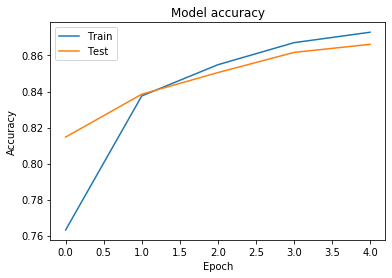

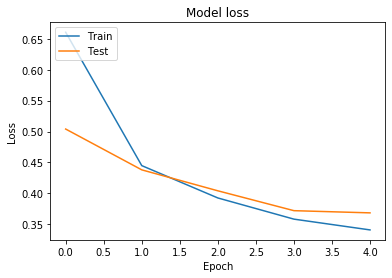

Time per epoch: [3.7094669342041016, 3.3159217834472656, 3.305434226989746, 3.274965763092041, 3.2601447105407715]
Total time: 16.865933418273926


In [75]:
#Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

##Matrice di confusione

Genero la matrice di confusione sul test set.

In [76]:
#Necessito di un array con tutte le labels

test_predictions = modelLSTM.predict_classes(test_images)

conf_matr = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = class_names, 
                          columns = class_names)

[[841   9  19  29   4   1  83   1  13   0]
 [  3 968   1  24   2   0   0   0   2   0]
 [ 15   4 815   9 105   1  44   0   7   0]
 [ 34  11  22 874  37   0  19   0   3   0]
 [  0   3 110  37 799   0  51   0   0   0]
 [  0   0   0   1   0 944   0  38   2  15]
 [175   5 123  32  74   0 568   0  23   0]
 [  0   0   0   0   0  18   0 924   0  58]
 [  1   0   5   6   5   1   3   4 974   1]
 [  0   0   0   0   0  12   0  32   1 955]]


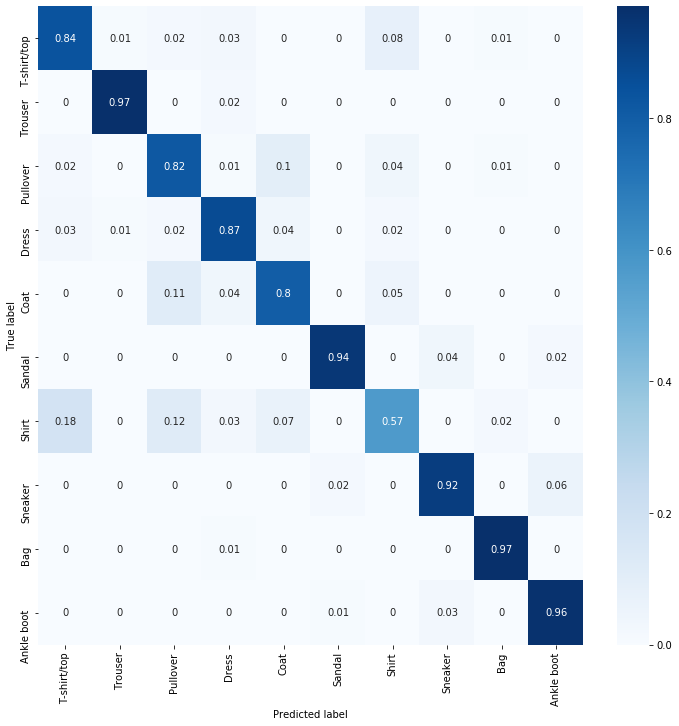

In [77]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()